/tmp/ipython-input-2756975540.py:39: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2756975540.py:39: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2756975540.py:39: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2756975540.py:39: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-2756975540.py:39: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

--- Starting Data Load and Calculation ---
Loading data...
Data loading complete.
Loaded data keys: dict_keys(['AAPL', 'GOOG', 'MSFT', 'TSLA', 'BTC-USD'])

Calculating volatility data...


Volatility calculation complete.

Calculated volatility data:


,daily_volatility,annualized_volatility,ATR,EWMA_volatility
AAPL,0.016920,0.268600,4.390000,0.015332
GOOG,0.018525,0.294074,6.473364,0.021482
MSFT,0.014160,0.224780,7.607856,0.010343
TSLA,0.038969,0.618621,15.666419,0.028629
BTC-USD,0.024574,0.390105,2124.272321,0.011614



Preparing and training ML model: Linear Regression

--- Preparing data for Linear Regression ML ---
Processing ticker: AAPL
Shape of AAPL df_temp after calculating daily_change, TR, ATR: (576, 8)
Columns of AAPL df_temp: [('Close', 'AAPL'), ('High', 'AAPL'), ('Low', 'AAPL'), ('Open', 'AAPL'), ('Volume', 'AAPL'), ('daily_change', ''), ('TR', ''), ('ATR', '')]
Shape of AAPL ml_data_ticker after creating samples and handling NaNs: (0, 0)
Skipping ML data preparation for AAPL as no valid samples were created.
Processing ticker: GOOG
Shape of GOOG df_temp after calculating daily_change, TR, ATR: (576, 8)
Columns of GOOG df_temp: [('Close', 'GOOG'), ('High', 'GOOG'), ('Low', 'GOOG'), ('Open', 'GOOG'), ('Volume', 'GOOG'), ('daily_change', ''), ('TR', ''), ('ATR', '')]
Shape of GOOG ml_data_ticker after creating samples and handling NaNs: (0, 0)
Skipping ML data preparation for GOOG as no valid samples were created.
Processing ticker: MSFT
Shape of MSFT df_temp after calculating daily_change,

""


Shape of ML data: (0, 0)
Columns of ML data: []
--- Linear Regression ML data preparation complete ---
Linear Regression model cannot be trained due to insufficient data after preparation.
Skipping prediction as the Linear Regression model was not successfully trained.
--- Data Load and Calculation Complete ---

Generating Heatmap...
No complete volatility data available for heatmap after filtering and dropping NaNs.

Generating Price with Volatility...



Generating Bar Chart...


/tmp/ipython-input-1148955578.py:648: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




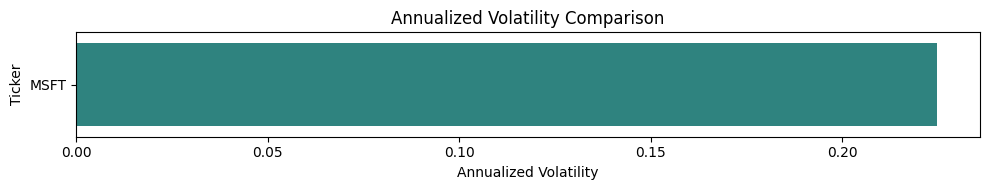

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display
import yfinance as yf
from datetime import date, timedelta
import pandas as pd
import numpy as np
# Temporarily comment out arch import due to persistent issues
# from arch import arch_model # Import arch_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import sys
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler

def obtener_datos_yf(tickers, start_date, end_date):
    """
    Downloads historical price data for the specified tickers and date range using yfinance.

    Args:
        tickers (list): A list of ticker symbols.
        start_date (datetime.date): The start date for data download.
        end_date (datetime.date). The end date for data download.

    Returns:
        dict: A dictionary where keys are ticker symbols and values are pandas DataFrames
              containing the historical data.
    """
    print("Loading data...")
    data = {}
    for ticker in tickers:
        try:
            df = yf.download(ticker, start=start_date, end=end_date)
            if df.empty:
                print(f"Warning: No data downloaded for ticker: {ticker}. Skipping.")
                continue
            # Check for required columns after download
            required_cols = ['Close', 'High', 'Low']
            if not all(col in df.columns for col in required_cols):
                 print(f"Warning: Required columns ({', '.join(required_cols)}) not found for ticker: {ticker}. Skipping.")
                 continue
            data[ticker] = df
        except Exception as e:
            print(f"An error occurred while downloading data for {ticker}: {e}", file=sys.stderr)
    print("Data loading complete.")
    print("Loaded data keys:", data.keys())
    return data

def calcular_volatilidad(data, atr_period=14, ewma_span=20):
    """
    Calculates various volatility metrics for the loaded data.

    Args:
        data (dict): A dictionary where keys are ticker symbols and values are pandas DataFrames
                     containing historical data with 'Close', 'High', and 'Low' columns.
        atr_period (int): The lookback period for ATR calculation.
        ewma_span (int): The span for EWMA calculation.


    Returns:
        pandas.DataFrame: A DataFrame where the index is ticker symbols and columns are
                          volatility metrics ('daily_volatility', 'annualized_volatility', 'ATR', 'EWMA_volatility').
                          GARCH_volatility column might be present but will contain NaN if calculation fails.
    """
    print("\nCalculating volatility data...")
    volatility_data = {}
    for ticker, df in data.items():
        # Ensure required columns are present
        required_cols = ['Close', 'High', 'Low']
        if not all(col in df.columns for col in required_cols):
            print(f"Skipping volatility calculation for {ticker} due to missing columns.")
            volatility_data[ticker] = {'daily_volatility': np.nan, 'annualized_volatility': np.nan, 'ATR': np.nan, 'EWMA_volatility': np.nan}
            continue

        try:
            df['daily_change'] = df['Close'].pct_change()
            daily_vol = df['daily_change'].std()
            annualized_vol = daily_vol * np.sqrt(252)
            df['TR'] = np.maximum(df['High'] - df['Low'], np.abs(df['High'] - df['Close'].shift(1)), np.abs(df['Low'] - df['Close'].shift(1))).fillna(0)
            df['ATR'] = df['TR'].rolling(window=atr_period).mean()
            ewma_vol = df['daily_change'].dropna().ewm(span=ewma_span).std().iloc[-1] if not df['daily_change'].dropna().empty else np.nan

            # GARCH calculation temporarily skipped due to persistent issues
            # garch_vol = np.nan # Initialize with NaN
            # returns = df['daily_change'].dropna() * 100 # GARCH models typically work with percentage returns
            # # Add more robust checks for returns data before fitting GARCH
            # print(f"Attempting GARCH for {ticker}: Returns length = {len(returns)}, Returns std dev = {returns.std()}")
            # if not returns.empty and len(returns) > 10 and returns.std() > 0: # Ensure enough data, variability, and not all NaNs/zeros
            #     try:
            #         # Ensure the index is suitable for arch_model (numeric or datetime-like)
            #         returns.index = np.arange(len(returns)) # Convert index to numeric

            #         # Fit GARCH(1,1) model
            #         model = arch_model(returns, vol='Garch', p=1, q=1)
            #         results = model.fit(disp='off') # disp='off' to suppress optimization output

            #         # Get the conditional volatility (last observation) and annualize it
            #         last_conditional_vol = results.conditional_volatility.iloc[-1]
            #         garch_vol = last_conditional_vol / 100 * np.sqrt(252) # Convert back to decimal and annualize

            #     except Exception as e:
            #         print(f"Could not fit GARCH model for {ticker}: {e}")
            # else:
            #      print(f"Not enough valid data points or variability to fit GARCH model for {ticker}. Need more than 10 non-zero/NaN returns with variability.")


            volatility_data[ticker] = {
                'daily_volatility': daily_vol,
                'annualized_volatility': annualized_vol,
                'ATR': df['ATR'].iloc[-1] if not df['ATR'].dropna().empty else np.nan,
                'EWMA_volatility': ewma_vol,
                # 'GARCH_volatility': garch_vol # Add GARCH volatility
            }
        except Exception as e:
            print(f"An error occurred during volatility calculation for {ticker}: {e}", file=sys.stderr)
            volatility_data[ticker] = {'daily_volatility': np.nan, 'annualized_volatility': np.nan, 'ATR': np.nan, 'EWMA_volatility': np.nan}


    volatility_df = pd.DataFrame.from_dict(volatility_data, orient='index')
    print("Volatility calculation complete.")
    print("\nCalculated volatility data:")
    display(volatility_df)
    return volatility_df

def prepare_data_for_ml_lr(data, window_size=5):
    """
    Prepares data for machine learning volatility prediction for Linear Regression.

    Args:
        data (dict): A dictionary where keys are ticker symbols and values are pandas DataFrames
                     containing historical data with 'Close', 'daily_change', and 'ATR' columns.
        window_size (int): The window size for creating lagged features.

    Returns:
        pandas.DataFrame: A DataFrame with features (lagged daily changes, lagged volatility metrics) and target (future daily change).
    """
    print("\n--- Preparing data for Linear Regression ML ---")
    ml_data_list = [] # Use a list to collect dataframes before concatenating
    for ticker, df in data.items():
        print(f"Processing ticker: {ticker}")
        # Ensure required columns are present
        required_cols = ['Close', 'High', 'Low'] # Need High and Low for TR calculation
        if not all(col in df.columns for col in required_cols):
            print(f"Skipping ML data preparation for {ticker} due to missing required columns: {required_cols}.")
            continue

        try:
            df_temp = df.copy() # Create a copy to avoid modifying the original dataframe in the loop
            df_temp['daily_change'] = df_temp['Close'].pct_change()
            df_temp['TR'] = np.maximum(df_temp['High'] - df_temp['Low'], np.abs(df_temp['High'] - df_temp['Close'].shift(1)), np.abs(df_temp['Low'] - df_temp['Close'].shift(1))).fillna(0)
            atr_period = 14 # Using default period
            # Calculate ATR first, which might introduce leading NaNs
            df_temp['ATR'] = df_temp['TR'].rolling(window=atr_period).mean()

            print(f"Shape of {ticker} df_temp after calculating daily_change, TR, ATR: {df_temp.shape}")
            print(f"Columns of {ticker} df_temp: {df_temp.columns.tolist()}")

            # --- Revised approach for creating lagged features and handling NaNs ---
            data_points = []
            # Iterate through the dataframe to create samples
            # Start from window_size to ensure enough previous data for lagged features
            # Go up to len(df_temp) - 1 because the target is the next day's change
            for i in range(window_size, len(df_temp) - 1):
                # Create a dictionary for the current data point
                current_sample = {}

                # Add lagged daily changes
                for j in range(window_size):
                    col_daily_change = f'lag_{j+1}_daily_change'
                    # Check for NaN in the lagged daily change
                    lagged_value = df_temp['daily_change'].iloc[i - j - 1] # Shifted back by j+1
                    if pd.isna(lagged_value):
                        break # If any lagged daily change is NaN, this sample is invalid
                    current_sample[col_daily_change] = lagged_value

                # If any lagged daily change was NaN, skip this sample
                if len(current_sample) != window_size:
                    continue

                # Add lagged rolling daily volatility
                # Calculate rolling std up to the current day (i-1) with window size, then get the value at (i-1)
                rolling_vol = df_temp['daily_change'].iloc[i-window_size : i].rolling(window=window_size).std()
                col_daily_volatility = f'lag_{window_size}_daily_volatility' # Only include the rolling vol at the end of the window
                # Check if the rolling volatility is NaN
                if rolling_vol.empty or pd.isna(rolling_vol.iloc[-1]):
                     continue # If rolling volatility is NaN, this sample is invalid
                current_sample[col_daily_volatility] = rolling_vol.iloc[-1]


                # Add lagged ATR
                # Get the ATR value at the end of the window (i-1)
                col_atr = f'lag_{window_size}_ATR' # Only include the ATR at the end of the window
                atr_value = df_temp['ATR'].iloc[i - 1] # Lagged ATR at the end of the window
                # Check if the lagged ATR is NaN
                if pd.isna(atr_value):
                    continue # If lagged ATR is NaN, this sample is invalid
                current_sample[col_atr] = atr_value


                # Add the target (next day's daily change)
                target_value = df_temp['daily_change'].iloc[i] # Target is at index i
                # Check if the target is NaN
                if pd.isna(target_value):
                    continue # If target is NaN, this sample is invalid
                current_sample['target_daily_change'] = target_value

                # Add the ticker
                current_sample['ticker'] = ticker

                data_points.append(current_sample)

            ml_data_ticker = pd.DataFrame(data_points)

            print(f"Shape of {ticker} ml_data_ticker after creating samples and handling NaNs: {ml_data_ticker.shape}")

            if ml_data_ticker.empty:
                print(f"Skipping ML data preparation for {ticker} as no valid samples were created.")
                continue

            ml_data_list.append(ml_data_ticker)

        except Exception as e:
            print(f"An error occurred during Linear Regression ML data preparation for {ticker}: {e}", file=sys.stderr)

    # Concatenate all dataframes from the list
    ml_data = pd.concat(ml_data_list) if ml_data_list else pd.DataFrame()

    print("\nPrepared data for Linear Regression ML:")
    display(ml_data.head())
    print(f"Shape of ML data: {ml_data.shape}")
    print(f"Columns of ML data: {ml_data.columns.tolist()}")
    print("--- Linear Regression ML data preparation complete ---")
    return ml_data


def prepare_data_for_ml_nn(data, window_size=5):
    """
    Prepares data for machine learning volatility prediction, formatted for a neural network.

    Args:
        data (dict): A dictionary where keys are ticker symbols and values are pandas DataFrames
                     containing historical data with 'Close', 'daily_change', and 'ATR' columns.
        window_size (int): The sequence length for the neural network.

    Returns:
        tuple: A tuple containing:
            - np.ndarray: Features array (reshaped for NN).
            - np.ndarray: Target array (scaled).
            - MinMaxScaler: Scaler fitted on the features.
            - MinMaxScaler: Scaler fitted on the target variable.
            - list: List of ticker symbols corresponding to the data points.
    """
    print("\n--- Preparing data for Neural Network ML ---")
    all_features_sequences = []
    all_targets = []
    all_tickers = []
    all_data_values_for_scaler = [] # To store data values for feature scaler fitting

    for ticker, df in data.items():
        print(f"Processing ticker: {ticker}")
        # Ensure required columns are present
        required_cols = ['Close', 'High', 'Low'] # Need High and Low for TR calculation
        if not all(col in df.columns for col in required_cols):
            print(f"Skipping ML data preparation for {ticker} due to missing required columns: {required_cols}.")
            continue

        try:
            df_temp = df.copy() # Create a copy to avoid modifying the original dataframe in the loop
            df_temp['daily_change'] = df_temp['Close'].pct_pct_change() # Corrected to pct_change
            df_temp['TR'] = np.maximum(df_temp['High'] - df_temp['Low'], np.abs(df_temp['High'] - df_temp['Close'].shift(1)), np.abs(df_temp['Low'] - df_temp['Close'].shift(1))).fillna(0)
            atr_period = 14 # Using default period
            df_temp['ATR'] = df_temp['TR'].rolling(window=atr_period).mean()
            print(f"Shape of {ticker} df_temp after calculating daily_change, TR, ATR: {df_temp.shape}")
            print(f"Columns of {ticker} df_temp: {df_temp.columns.tolist()}")


            # Select features for the neural network (daily change, ATR)
            features_df = df_temp[['daily_change', 'ATR']].copy()

            # --- Revised approach for creating sequences and handling NaNs ---
            sequences = []
            targets = []
            tickers_list = []

            # Iterate through the dataframe to create sequences and targets
            # Start from window_size to ensure enough previous data for the sequence
            # Go up to len(features_df) - 1 because the target is the next day's value
            for i in range(window_size, len(features_df) - 1):
                # Extract the sequence of features (from i-window_size to i-1)
                sequence_data = features_df.iloc[i-window_size : i].values

                # Extract the target value (at index i, which is the next day relative to the sequence)
                target_value = features_df['daily_change'].iloc[i] # Target is the daily change at index i

                # Check for NaNs within the sequence and the target
                if not np.isnan(sequence_data).any() and not pd.isna(target_value):
                    sequences.append(sequence_data)
                    targets.append(target_value)
                    tickers_list.append(ticker)

            print(f"Number of valid sequences created for {ticker}: {len(sequences)}")

            if not sequences:
                print(f"Skipping ML data preparation for {ticker}: No valid sequences created for window size {window_size}.")
                continue

            all_features_sequences.extend(sequences)
            all_targets.extend(targets)
            all_tickers.extend(tickers_list) # Keep track of tickers

            # Store valid feature data for scaler fitting (use data points that were actually used in sequences)
            # Collect the feature data from the sequences that were created
            valid_features_for_scaler = np.concatenate(sequences, axis=0) if sequences else np.array([])
            if valid_features_for_scaler.size > 0:
                all_data_values_for_scaler.append(valid_features_for_scaler)


        except Exception as e:
             print(f"An error occurred during Neural Network ML data preparation for {ticker}: {e}", file=sys.stderr)


    if not all_features_sequences:
        print("\nNo valid data available to prepare for Neural Network ML.")
        print("--- Neural Network ML data preparation failed ---")
        return np.array([]), np.array([]), None, None, []

    # Convert lists to numpy arrays
    X_np = np.array(all_features_sequences)
    y_np = np.array(all_targets)

    print(f"Shape of unscaled target data: {y_np.shape}")
    print(f"Data type of unscaled target data: {y_np.dtype}")


    # Concatenate all data values from all tickers to fit the feature scaler
    concatenated_features_for_scaling = np.concatenate(all_data_values_for_scaler, axis=0) if all_data_values_for_scaler else np.array([])

    if concatenated_features_for_scaling.size == 0:
         print("\nNo valid feature data available for scaling.")
         print("--- Neural Network ML data preparation failed ---")
         return np.array([]), np.array([]), None, None, []

    # Scale the features
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    feature_scaler.fit(concatenated_features_for_scaling)

    # Scale the features in the sequences using the fitted scaler
    scaled_all_features = np.array([feature_scaler.transform(seq) for seq in all_features_sequences])


    # Scale the target variable separately
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    # Fit the target scaler on all collected unscaled targets (y_np)
    y_scaled = target_scaler.fit_transform(y_np.reshape(-1, 1))


    print("\nPrepared data for Neural Network ML:")
    print(f"Features shape: {scaled_all_features.shape}")
    print(f"Target shape: {y_scaled.shape}")
    print(f"Features data type: {scaled_all_features.dtype}")
    print(f"Target data type: {y_scaled.dtype}")

    return scaled_all_features, y_scaled, feature_scaler, target_scaler, all_tickers


def build_neural_network_model(input_shape):
    """
    Builds a simple neural network model (LSTM).

    Args:
        input_shape (tuple): The shape of the input data (time steps, features).

    Returns:
        tensorflow.keras.models.Sequential: The built neural network model.
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1)) # Predicting a single value (daily change)

    model.compile(optimizer='adam', loss='mean_squared_error')
    print("\nNeural Network model built.")
    model.summary()
    return model

def train_ml_model(model_type, X_train, y_train, input_shape=None):
    """
    Trains the specified machine learning model.

    Args:
        model_type (str): Type of model ('Linear Regression' or 'Neural Network (LSTM)').
        X_train (np.ndarray or pandas.DataFrame): Training features.
        y_train (np.ndarray or pandas.Series): Training target.
        input_shape (tuple, optional): Input shape for NN models. Defaults to None.

    Returns:
        model: The trained model.
        list: List of feature names (for LR).
    """
    trained_model = None
    features = None

    print(f"\nAttempting to train {model_type} model...")

    if model_type == 'Linear Regression':
        if X_train is None or y_train is None or X_train.empty or y_train.empty or len(X_train) < 2: # Need at least 2 samples for LR
            print(f"Not enough data available to train the {model_type} model. Need at least 2 samples.")
            if X_train is not None: print(f"X_train shape: {X_train.shape}")
            if y_train is not None: print(f"y_train shape: {y_train.shape}")
            return None, None
        try:
            print(f"X_train shape before LR fit: {X_train.shape}")
            print(f"y_train shape before LR fit: {y_train.shape}")
            print(f"X_train data type: {X_train.dtype}")
            print(f"y_train data type: {y_train.dtype}")

            model = LinearRegression()
            model.fit(X_train, y_train)
            trained_model = model
            features = X_train.columns.tolist()
            print(f"\n{model_type} model trained.")
        except Exception as e:
            print(f"An error occurred during {model_type} model training: {e}", file=sys.stderr)

    elif model_type == 'Neural Network (LSTM)':
        if X_train is None or y_train is None or X_train.size == 0 or y_train.size == 0 or input_shape is None or len(X_train) < 1: # Need at least 1 sample for NN
             print(f"Not enough data or input shape available to train the {model_type} model. Need at least 1 sample and input shape.")
             if X_train is not None: print(f"X_train shape: {X_train.shape}")
             if y_train is not None: print(f"y_train shape: {y_train.shape}")
             print(f"Input shape: {input_shape}")
             return None, None
        try:
            print(f"X_train shape before NN fit: {X_train.shape}")
            print(f"y_train shape before NN fit: {y_train.shape}")
            print(f"X_train data type: {X_train.dtype}")
            print(f"y_train data type: {y_train.dtype}")
            print(f"Input shape for NN model: {input_shape}")


            model = build_neural_network_model(input_shape)
            print("\nTraining Neural Network model...")
            # Use the scaled target y_train for NN training
            model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=0) # Set verbose=0 to reduce output
            trained_model = model
            features = ['daily_change', 'ATR'] # Features used for NN
            print("Neural Network model training complete.")
        except Exception as e:
            print(f"An error occurred during {model_type} model training: {e}", file=sys.stderr)

    else:
        print(f"Unknown ML model type: {model_type}")

    return trained_model, features

class VolatilityRadar:
    def __init__(self, tickers, start_date=None, end_date=None):
        self.tickers = tickers
        self.start_date = start_date if start_date else date.today() - timedelta(days=90)
        self.end_date = end_date if end_date else date.today()
        self.data = {}
        self.volatility_df = pd.DataFrame()
        self.ml_data_lr = pd.DataFrame() # Data for Linear Regression
        self.ml_data_nn = None # Data for Neural Network (features)
        self.ml_target_nn_scaled = None # Scaled target for NN
        self.ml_feature_scaler_nn = None # Feature scaler for NN
        self.ml_target_scaler_nn = None # Target scaler for NN
        self.ml_tickers_nn = [] # Tickers for NN data
        self.ml_model_lr = None # Linear Regression model
        self.ml_model_nn = None # Neural Network model
        self.ml_features_lr = None # Features for Linear Regression
        self.ml_model_type = 'Linear Regression' # Default ML model type
        self.ml_evaluation_metrics = {} # Dictionary to store evaluation metrics

        self.ticker_select = None
        self.metric_select = None
        self.graph_type_dropdown = None
        self.generate_button = None
        self.export_button = None
        self.start_date_picker = None # Add start date picker
        self.end_date_picker = None # Add end date picker
        self.ticker_input = None # Add ticker input
        self.rolling_window_slider = None # Add rolling window slider
        self.ml_window_slider = None # Add ML window slider
        self.ml_model_type_dropdown = None # Add ML model type dropdown
        self.load_button = None # Add load button


    def _get_widget_values(self):
        """Retrieves current values from interactive widgets."""
        current_start_date = self.start_date_picker.value if self.start_date_picker and self.start_date_picker.value else self.start_date
        current_end_date = self.end_date_picker.value if self.end_date_picker and self.end_date_picker.value else self.end_date
        current_tickers = [t.strip() for t in self.ticker_input.value.split(',') if t.strip()] if self.ticker_input and self.ticker_input.value else self.tickers
        current_rolling_window = self.rolling_window_slider.value if self.rolling_window_slider else 20
        current_ml_window_size = self.ml_window_slider.value if self.ml_window_slider else 5
        current_ml_model_type = self.ml_model_type_dropdown.value if self.ml_model_type_dropdown else 'Linear Regression'

        return current_start_date, current_end_date, current_tickers, current_rolling_window, current_ml_window_size, current_ml_model_type

    def _reset_state(self):
        """Resets the internal state of the radar."""
        self.data = {}
        self.volatility_df = pd.DataFrame()
        self.ml_data_lr = pd.DataFrame()
        self.ml_data_nn = None
        self.ml_target_nn_scaled = None
        self.ml_feature_scaler_nn = None
        self.ml_target_scaler_nn = None
        self.ml_tickers_nn = []
        self.ml_model_lr = None
        self.ml_model_nn = None
        self.ml_features_lr = None
        self.ml_evaluation_metrics = {}

        # Clear widget options
        if self.ticker_select:
            self.ticker_select.options = []
        if self.metric_select:
            self.metric_select.options = []

    def _prepare_and_train_ml(self, current_ml_model_type, current_ml_window_size):
         """Prepares data and trains the selected ML model."""
         self.ml_model_type = current_ml_model_type # Update the instance variable
         self.ml_model_lr = None # Reset models before training
         self.ml_model_nn = None
         self.ml_evaluation_metrics = {} # Reset evaluation metrics

         print(f"\nPreparing and training ML model: {current_ml_model_type}")


         if current_ml_model_type == 'Linear Regression':
             self.ml_data_lr = prepare_data_for_ml_lr(self.data, window_size=current_ml_window_size)
             if not self.ml_data_lr.empty:
                 # Separate features and target for training
                 # Ensure 'ticker' column is dropped before training features
                 X_train = self.ml_data_lr.drop(['target_daily_change', 'ticker'], axis=1)
                 y_train = self.ml_data_lr['target_daily_change']
                 self.ml_model_lr, self.ml_features_lr = train_ml_model('Linear Regression', X_train, y_train)

                 if self.ml_model_lr: # Only evaluate if model was successfully trained
                     # Evaluate Linear Regression model
                     self.ml_evaluation_metrics.update(evaluate_ml_model('Linear Regression', self.ml_model_lr, self.ml_data_lr, self.ml_features_lr))
             else:
                 print("Linear Regression model cannot be trained due to insufficient data after preparation.")


         elif current_ml_model_type == 'Neural Network (LSTM)':
             # Correctly unpack the tuple returned by prepare_data_for_ml_nn
             self.ml_data_nn, self.ml_target_nn_scaled, self.ml_feature_scaler_nn, self.ml_target_scaler_nn, self.ml_tickers_nn = prepare_data_for_ml_nn(self.data, window_size=current_ml_window_size)

             if self.ml_data_nn is not None and self.ml_data_nn.size > 0 and self.ml_target_nn_scaled is not None and self.ml_target_nn_scaled.size > 0:
                 # Determine input shape for NN based on prepared data
                 # Shape is (samples, time steps, features) -> input shape is (time steps, features)
                 input_shape = (self.ml_data_nn.shape[1], self.ml_data_nn.shape[2])
                 self.ml_model_nn, _ = train_ml_model('Neural Network (LSTM)', self.ml_data_nn, self.ml_target_nn_scaled, input_shape=input_shape)

                 if self.ml_model_nn: # Only evaluate if model was successfully trained
                     # Evaluate Neural Network model
                     self.ml_evaluation_metrics.update(evaluate_ml_model('Neural Network (LSTM)', self.ml_model_nn, self.ml_data_nn, None, target_scaler_nn=self.ml_target_scaler_nn, window_size=current_ml_window_size))

             else:
                  print("Neural Network model cannot be trained due to insufficient data after preparation.")


    def _integrate_predictions(self, current_ml_model_type, current_ml_window_size):
        """Makes predictions and integrates them into the volatility DataFrame."""
        predicted_vols = {}
        # Ensure the correct model is passed for prediction based on the trained model type
        ml_model_to_use = self.ml_model_lr if current_ml_model_type == 'Linear Regression' else self.ml_model_nn

        if ml_model_to_use: # Only attempt prediction if a model was successfully trained
            if current_ml_model_type == 'Linear Regression':
                predicted_vols = predict_volatility('Linear Regression', self.data, ml_model_to_use, self.ml_data_lr, self.ml_features_lr)
            elif current_ml_model_type == 'Neural Network (LSTM)':
                 predicted_vols = predict_volatility('Neural Network (LSTM)', self.data, ml_model_to_use, self.ml_data_nn, None, feature_scaler_nn=self.ml_feature_scaler_nn, target_scaler_nn=self.ml_target_scaler_nn, window_size=current_ml_window_size)
        else:
            print(f"Skipping prediction as the {current_ml_model_type} model was not successfully trained.")


        if predicted_vols:
            predicted_series = pd.Series(predicted_vols)
            self.volatility_df['Predicted_Volatility'] = self.volatility_df.index.map(predicted_series)
        else:
             # If no predictions were made, ensure the column exists but contains NaNs
             if 'Predicted_Volatility' not in self.volatility_df.columns:
                  self.volatility_df['Predicted_Volatility'] = np.nan
             else:
                  self.volatility_df['Predicted_Volatility'] = np.nan


    def load_and_calculate(self):
        """Loads data and calculates volatility metrics, trains ML models, and evaluates them."""
        current_start_date, current_end_date, current_tickers, current_rolling_window, current_ml_window_size, self.ml_model_type = self._get_widget_values()

        print("--- Starting Data Load and Calculation ---")
        self._reset_state() # Reset state before loading new data

        if not current_tickers:
             print("Please enter at least one ticker.")
             print("--- Data Load and Calculation Failed ---")
             return

        self.data = obtener_datos_yf(current_tickers, current_start_date, current_end_date)

        # Check if any data was loaded before proceeding
        if not self.data:
             print("No data loaded for any of the provided tickers and date range.")
             print("--- Data Load and Calculation Failed ---")
             return

        self.volatility_df = calcular_volatilidad(self.data)

        # Prepare data and train ML model based on selected type
        self._prepare_and_train_ml(self.ml_model_type, current_ml_window_size)

        # Integrate ML predictions into volatility_df
        self._integrate_predictions(self.ml_model_type, current_ml_window_size)

        # Update widget options after data is loaded
        if self.ticker_select:
             # Ensure options are updated even if volatility_df is empty (though it shouldn't be if data loaded)
             self.ticker_select.options = self.volatility_df.index.tolist() if not self.volatility_df.empty else []
        if self.metric_select:
              self.metric_select.options = self.volatility_df.columns.tolist() if not self.volatility_df.empty else []

        print("--- Data Load and Calculation Complete ---")
        # Display evaluation metrics if available
        if self.ml_evaluation_metrics:
             print("\nML Model Evaluation Metrics:")
             for metric, value in self.ml_evaluation_metrics.items():
                 print(f"  {metric}: {value:.6f}")


    def create_widgets(self):
        """Creates and displays ipywidgets for user interaction."""
        # Initialize date pickers
        self.start_date_picker = widgets.DatePicker(
            description='Start Date:',
            disabled=False,
            value=self.start_date
        )
        self.end_date_picker = widgets.DatePicker(
            description='End Date:',
            disabled=False,
            value=self.end_date
        )

        # Initialize ticker input
        self.ticker_input = widgets.Text(
            value=','.join(self.tickers),
            description='Tickers (comma-separated):',
            disabled=False,
            continuous_update=False,
            layout=widgets.Layout(width='50%')
        )

        # Initialize sliders for rolling window and ML window size
        self.rolling_window_slider = widgets.IntSlider(
            value=20,
            min=5,
            max=100,
            step=1,
            description='Rolling Volatility Window:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
        )

        self.ml_window_slider = widgets.IntSlider(
            value=5,
            min=1,
            max=20,
            step=1,
            description='ML Feature Window:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d',
        )

        # Initialize ML model type dropdown
        self.ml_model_type_dropdown = widgets.Dropdown(
            options=['Linear Regression', 'Neural Network (LSTM)'],
            description='ML Model Type:',
            disabled=False,
            value=self.ml_model_type
        )


        # Initialize other widgets (options will be updated after data load)
        self.ticker_select = widgets.SelectMultiple(
            options=[], # Empty initially, will be populated after load_and_calculate
            description='Select Tickers:',
            disabled=False,
            layout=widgets.Layout(width='50%', height='100px')
        )

        self.metric_select = widgets.SelectMultiple(
            options=[], # Empty initially, will be populated after load_and_calculate
            description='Select Metrics:',
            disabled=False,
            layout=widgets.Layout(width='50%', height='100px')
        )

        self.graph_type_dropdown = widgets.Dropdown(
            options=['Radar', 'Bar Chart', 'Heatmap', 'Price with Volatility', 'Time Series Volatility'], # Add new option
            description='Select Graph Type:',
            disabled=False
        )

        self.generate_button = widgets.Button(
            description='Generate Plot',
            disabled=False,
            button_style='',
            tooltip='Click to generate the selected plot',
            icon='chart-bar'
        )
        self.generate_button.on_click(self.on_button_click)

        self.export_button = widgets.Button(
            description='Export to CSV',
            disabled=False,
            button_style='success',
            tooltip='Click to export volatility results to CSV',
            icon='download'
        )
        self.export_button.on_click(self.on_export_button_click)

        # Add a button to trigger data loading and calculation
        self.load_button = widgets.Button(
            description='Load Data & Calculate',
            disabled=False,
            button_style='primary',
            tooltip='Click to load data and calculate volatility metrics',
            icon='download'
        )
        self.load_button.on_click(self.on_load_button_click)


        # Arrange widgets in a layout
        date_widgets = widgets.HBox([self.start_date_picker, self.end_date_picker])
        slider_widgets = widgets.VBox([self.rolling_window_slider, self.ml_window_slider])
        ml_widgets = widgets.VBox([self.ml_model_type_dropdown])
        input_widgets = widgets.VBox([self.ticker_input, date_widgets, slider_widgets, ml_widgets, self.load_button])
        selection_widgets = widgets.HBox([self.ticker_select, self.metric_select])
        control_widgets = widgets.VBox([self.graph_type_dropdown, widgets.HBox([self.generate_button, self.export_button])])


        # Display the widgets
        display(widgets.VBox([
            input_widgets,
            selection_widgets,
            control_widgets
        ]))

    def on_load_button_click(self, b):
        """Handles the load data button click event."""
        self.load_and_calculate()


    def on_button_click(self, b):
        """Handles the button click event and triggers plotting based on selections."""
        selected_tickers = list(self.ticker_select.value) # Convert tuple to list
        selected_metrics = list(self.metric_select.value) # Convert tuple to list
        selected_graph_type = self.graph_type_dropdown.value

        if not selected_tickers:
            print("Please select at least one ticker.")
            return

        if selected_graph_type != 'Bar Chart' and selected_graph_type != 'Price with Volatility' and selected_graph_type != 'Time Series Volatility' and not selected_metrics:
             print("Please select at least one metric for Radar or Heatmap.")
             return

        print(f"\nGenerating {selected_graph_type}...")

        # Pass rolling window value to plotting functions that use it
        current_rolling_window = self.rolling_window_slider.value if self.rolling_window_slider else 20

        if selected_graph_type == 'Radar':
            graficar_radar(self.volatility_df, tickers_to_plot=selected_tickers, metrics_to_plot=selected_metrics)
        elif selected_graph_type == 'Bar Chart':
            graficar_barras(self.volatility_df, tickers_to_plot=selected_tickers)
        elif selected_graph_type == 'Heatmap':
            graficar_heatmap(self.volatility_df, tickers_to_plot=selected_tickers, metrics_to_plot=selected_metrics)
        elif selected_graph_type == 'Price with Volatility':
            if len(selected_tickers) > 1:
                 print("Please select only one ticker for 'Price with Volatility' plot.")
                 return
            graficar_precio_volatilidad(self.data, selected_tickers[0], rolling_window=current_rolling_window)
        elif selected_graph_type == 'Time Series Volatility': # Handle new plot type
             if len(selected_tickers) > 1:
                 print("Please select only one ticker for 'Time Series Volatility' plot.")
                 return
             graficar_time_series_volatility(self.data, selected_tickers[0], rolling_window=current_rolling_window)

    def on_export_button_click(self, b):
        """Handles the export button click event."""
        exportar_resultados_csv(self.volatility_df)


# Instantiate the class and run the methods
# Initial tickers are set in the constructor, but can be overridden by the widget input
radar = VolatilityRadar(tickers=['AAPL', 'GOOG', 'MSFT', 'TSLA', 'BTC-USD'], start_date=date(2023, 6, 1), end_date=date.today())
radar.create_widgets() # Create and display widgets first
# Then, the user will use the "Load Data & Calculate" button to trigger data loading and calculations